# Create a final forecast

## Introduction

In this notebook, I create a final forecast, visualize it and submit the results to the data-science competition.

## Set up

In [1]:
# Eliminate some future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import global libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# Import converters to allow matplotlib to use dates and eliminte warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Set some Seaborn defaults
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('muted')

In [3]:
# Import homegrown functions
import my_func
import importlib

In [4]:
# Import notebook-specific libraries

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Load data

In [5]:
# Load training data
# Here, it's the prep'd (and not split) training sets.  That is, I'm training on all non-content data
train_sj = pd.read_pickle('../sb_cap2_nb-99_data/prep_sj.pickle')
train_iq = pd.read_pickle('../sb_cap2_nb-99_data/prep_iq.pickle')
train_log_sj =  pd.read_pickle('../sb_cap2_nb-99_data/prep_log_sj.pickle')
train_log_iq =  pd.read_pickle('../sb_cap2_nb-99_data/prep_log_iq.pickle')

# Load submission template
sub_org = pd.read_csv('../sb_cap2_nb-99_data/original_submission_format.csv') 

## Define functions

In [6]:
def prep_for_prophet(df):
    """Prepare dataframe as Prophet is expecting"""
    
    # Move date from index to column
    prep_df = df.copy()
    prep_df.reset_index(inplace=True)
    
    # Rename columns
    prep_df.rename(columns = {'week_start_date':'ds', 'total_cases':'y'}, inplace = True)
    
    return prep_df

In [7]:
def combine_actual_and_prophet_forecast_into_single_df(actual, prophet):
    
    forecast_values = list(prophet['yhat'].tail(len(actual)))
    actual_df = actual.copy()
    actual_df['forecast'] = forecast_values
    actual_df.columns = ['actual', 'forecast']

    return actual_df

## Prepare data and templates

In [8]:
# Clean up the submission template for San Juan
sub_sj = sub_org.copy()
sub_sj.drop(sub_sj[sub_sj['city'] != 'sj'].index, inplace=True)

# Get the number of forecast periods
forc_periods_sj = len(sub_sj)
print('I am asked to forecast the San Jose data for {} periods.'.format(forc_periods_sj))

# # Validate
# sub_sj

I am asked to forecast the San Jose data for 260 periods.


In [9]:
# Clean up the submission tempalte for Iquitos
sub_iq = sub_org.copy()
sub_iq.drop(sub_iq[sub_iq['city'] != 'iq'].index, inplace=True)

# Get the number of forecast period
forc_periods_iq = len(sub_iq)
print('I am asked to forecast the Iquitos data for {} periods.'.format(forc_periods_iq))

# # Validate
# sub_qi

I am asked to forecast the Iquitos data for 156 periods.


In [10]:
# Test
assert len(sub_org) == forc_periods_sj + forc_periods_iq

In [11]:
# Create a template dataframe to track my competition results
comp_df = pd.DataFrame(columns=['date', 'submission', 'model', 'sj details', 'iq details', 
                                'score', 'rank', 'competitors'])

## Forecast with best model - San Juan

My best model is from the additive regression approach using FB Profit.  In the prior notebook I call this model, 'variation 4 - stabilized trend - log data.'

In [12]:
this_run_train = train_log_sj
this_run_forc_periods = forc_periods_sj
this_run_submission_df = sub_sj

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


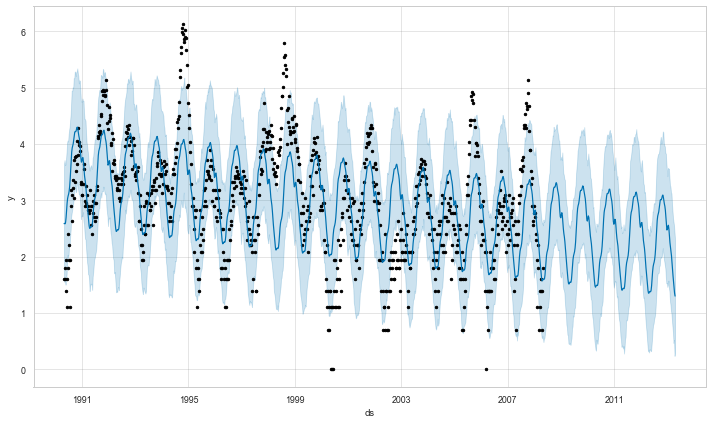

In [13]:
# Prep, instantiate, fit and forecast
this_run_train_p_ready = prep_for_prophet(this_run_train)
model = Prophet(weekly_seasonality=False, daily_seasonality=False, 
                changepoint_prior_scale=.0025, n_changepoints=10)
fit = model.fit(this_run_train_p_ready)
forc_df_frame = model.make_future_dataframe(freq='W', periods=this_run_forc_periods)
forc = model.predict(forc_df_frame)

model.plot(forc);

# model.plot_components(forc);

In [14]:
# Extract, transform back and round forecast values
forc_lst_log = forc['yhat'].tail(this_run_forc_periods)
forc_lst = np.expm1(forc_lst_log)
forc_lst = np.round_(forc_lst)
forc_lst = list(forc_lst)

In [15]:
# Add forecast value to submission data frame
this_run_submission_df['total_cases'] = forc_lst
submission_sj = this_run_submission_df

## Pull a sample week from the final forecast

In [16]:
# Extract, transform back and round forecast values - lower bound
forc_lst_log_lower = forc['yhat_lower'].tail(this_run_forc_periods)
forc_lst_lower = np.expm1(forc_lst_log_lower)
forc_lst_lower = np.round_(forc_lst_lower)
forc_lst_lower = list(forc_lst_lower)

In [17]:
# Extract, transform back and round forecast values - upper bound
forc_lst_log_upper = forc['yhat_upper'].tail(this_run_forc_periods)
forc_lst_upper = np.expm1(forc_lst_log_upper)
forc_lst_upper = np.round_(forc_lst_upper)
forc_lst_upper = list(forc_lst_upper)

In [18]:
## Get the forecast values for a period 6-months out in San Juan
sample_forc_periods = 26 - 1 # 6 months of weeks converted to 0-based index
sample_date = forc['ds'].tail(this_run_forc_periods).iloc[sample_forc_periods]
print('Here is a forecast {} periods beyond all supplied data'.format(sample_forc_periods + 1))
print('The date:         {}'.format(sample_date))
print('The forecast:     {}'.format(forc_lst[sample_forc_periods]))
print('The lower bound:  {}'.format(forc_lst_lower[sample_forc_periods]))
print('The upper bound:  {}'.format(forc_lst_upper[sample_forc_periods]))

Here is a forecast 26 periods beyond all supplied data
The date:         2008-10-19 00:00:00
The forecast:     26.0
The lower bound:  8.0
The upper bound:  70.0


## Forecast with best model - Iquitos

In [19]:
this_run_train = train_log_iq
this_run_forc_periods = forc_periods_iq
this_run_submission_df = sub_iq

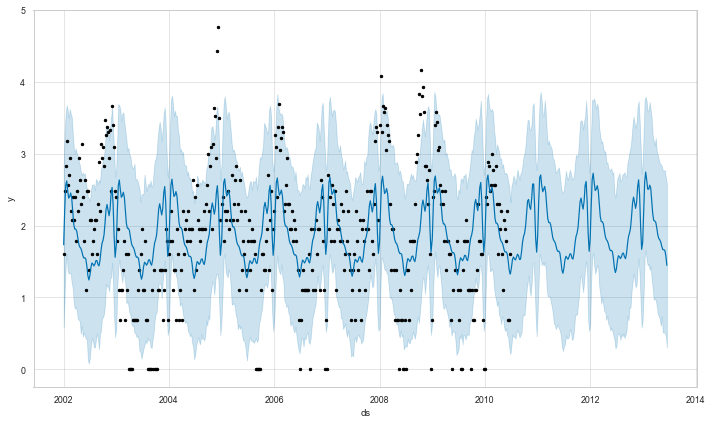

In [20]:
# Prep, instantiate, fit and forecast
this_run_train_p_ready = prep_for_prophet(this_run_train)
model = Prophet(weekly_seasonality=False, daily_seasonality=False, 
                changepoint_prior_scale=.0025, n_changepoints=10)
fit = model.fit(this_run_train_p_ready)
forc_df_frame = model.make_future_dataframe(freq='W', periods=this_run_forc_periods)
forc = model.predict(forc_df_frame)

model.plot(forc);
# model.plot_components(forc);

In [21]:
# Extract, transform back and round forecast values
forc_lst_log = forc['yhat'].tail(this_run_forc_periods)
forc_lst = np.expm1(forc_lst_log)
forc_lst = np.round_(forc_lst)
forc_lst = list(forc_lst)

In [22]:
# Add to submission dataframe
this_run_submission_df['total_cases'] = forc_lst
submission_iq = this_run_submission_df

## Combine, clean and save in a form to submit to the competition

In [23]:
# Clean up
submission = submission_sj.append(submission_iq)
submission['total_cases'] = submission['total_cases'].astype('int64')
# submission.dtypes

In [24]:
assert len(sub_org) == len(submission)

In [25]:
submission.to_csv('../sb_cap2_nb-99_data/submission_2020-05-27.csv', index=False)

## Manually submit scores to competition

This is done outside of the notebook via the competition's site.

## Track resulting scores

In [26]:
date = '2020-05-27'
submission = 1
model = 'fbprophet'
sj_details = 'stabilized trend, log data'
iq_details = 'stabilized trend, log data'
score = 30.5865
rank = 2926
competitors = 9051

In [27]:
comp_df.loc[len(comp_df)] = [date, submission, model, sj_details, iq_details, score, rank, competitors]

In [28]:
comp_df

,date,submission,model,sj details,iq details,score,rank,competitors
0,2020-05-27,1,fbprophet,"stabilized trend, log data","stabilized trend, log data",30.5865,2926,9051


In [29]:
comp_df.to_pickle('../sb_cap2_nb-99_data/submissions_after_nbk_20.pickle')

## Commentary

I was a bit surprised by the differences in my training scores and my submission score.

* I was expected an submission MAE of 15 to 20, something a bit (but not too much) worse than my training error.
* I got a submission error that was 30--2 times worse than my training error.
* This makes me think I'm overfitting.
* Plus, this makes me think about the limits of my 'univariate' approach.  Recall that I am "toss out" all the weather-related data because I want to focus on univariate time series.  I suspect that, while a good univariate time series, might capture baseline trend and seasonality, a univariate time series is not going to capture the occasional "spikes" of cases. 